In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import torchvision as tv
from torch.utils.data import DataLoader
from torchvision import transforms

# set random seed
torch.manual_seed(0)
torch.cuda.manual_seed(0)


class MaskedConv2d(nn.Module):
    def __init__(self, n_in, n_out, filter_mask, pad = 0):
        super().__init__()
        self.kernel_size = 3
        self.register_buffer('filter_mask', filter_mask)
        self.conv = nn.Conv2d(
            in_channels=n_in,
            out_channels=n_out,
            kernel_size=self.kernel_size,
            stride=1,
            bias=False,
            padding = pad
        )
        
        # self.conv.weight.data.fill_(1/torch.sum(torch.ones_like(self.filter_mask)))

    
    def forward(self, x):
        self._mask_conv_filter()
        return self.conv(x)
    
    
    def _mask_conv_filter(self):
        with torch.no_grad():
            temp = self.conv.weight * self.filter_mask                
            self.conv.weight.data = temp


class LabCNN(nn.Module):
    def __init__(self, fin, n_classes, mask) -> None:
        super(LabCNN, self).__init__()

        self.in_channels = fin
        self.n_classes = n_classes

        self.conv = MaskedConv2d(fin, 8, mask)
        self.fc = nn.LazyLinear(n_classes)


    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_channels) + ' -> ' \
               + str(self.n_classes) + ')'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_size = (8, 8)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Resize(image_size, antialias=True)])
dataset = tv.datasets.MNIST('./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


mask = torch.tensor([[[
    [0., 0., 0.],
    [0., 1., 0.],
    [0., 0., 0.]
    ]]])

model = LabCNN(1, 10, mask)
model.cuda()


criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(2):
    for image, label in loader:
        image = image.cuda()
        label = label.cuda()
        optimizer.zero_grad()
        output = model(image)
        loss = criteria(output, label)
        loss.backward()
        optimizer.step()
    print(f'loss: {loss.item()}')
model.conv._mask_conv_filter()

loss: 0.2648853659629822
loss: 0.31997302174568176


In [4]:
model.conv.conv.weight[0, 0]

tensor([[ 0.0000, -0.0000, -0.0000],
        [ 0.0000, -1.1968, -0.0000],
        [-0.0000, -0.0000,  0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [5]:
import torch
import torchvision
import matplotlib.pyplot as plt
from gcn.layers import GCLayer


batch_size = 7
in_channels = 3
out_channels = 4
image_size = 4

image = torch.eye(image_size)
image = torch.stack([image for _ in range(in_channels)])
image = torch.stack([image for _ in range(batch_size)])

# image = torch.rand(batch_size, in_channels, image_size, image_size)

gcn = GCLayer(image_size, in_channels, out_channels, False)

out = gcn(image)

In [15]:
image = torch.eye(4)

# image = torch.rand(1, 3, 4, 4)
# image = image.view(image.size(0), image.size(1), -1, 1)

weight = torch.ones(16, 16) * gcn.adj
out = torch.matmul(gcn.adj, image.view(16, 1))

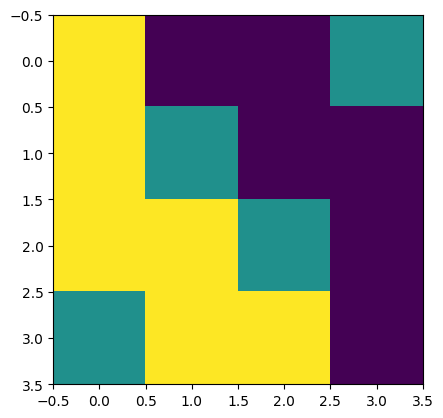

In [16]:
plt.imshow(out.view(4, 4).detach().numpy())

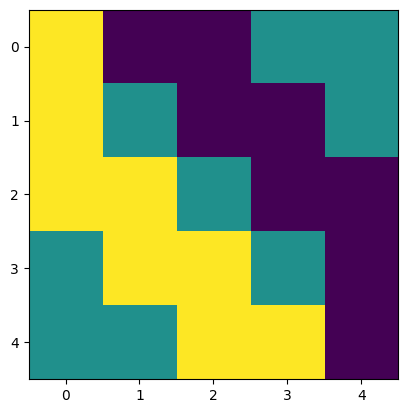

In [4]:
import torch
import torch.nn as nn


image = torch.eye(5)
conv = torch.nn.Conv2d(1, 1, 3, padding=1, bias=False)
conv_filter = torch.tensor([[[[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]]], dtype=torch.float32)
conv.weight.data = nn.Parameter(conv_filter.view(1, 1, 3, 3))
image = image.view(1, 1, 5, 5)
out = conv(image)
plt.imshow(out[0, 0].detach().numpy().reshape(5, 5))

/home/hesam/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


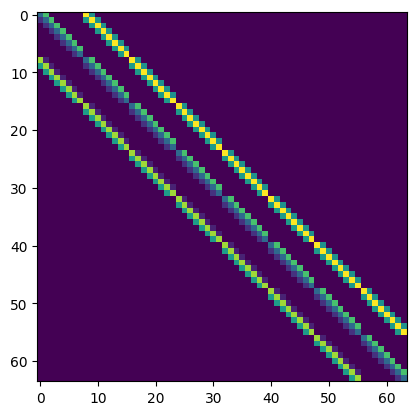

loss: 0.29355746507644653, accuracy: 85.27666666666667%, time: 305.92234468460083
loss: 0.3675607442855835, accuracy: 87.39416666666666%, time: 302.1028845310211
loss: 0.18709446489810944, accuracy: 88.51555555555557%, time: 298.3787133693695
loss: 0.1068539097905159, accuracy: 89.2325%, time: 298.3287181854248
loss: 0.11090225726366043, accuracy: 89.74600000000001%, time: 298.1383743286133
loss: 0.12855130434036255, accuracy: 90.13194444444444%, time: 298.32515716552734
loss: 0.2611790597438812, accuracy: 90.44166666666666%, time: 299.00697445869446
loss: 0.4203495681285858, accuracy: 90.69874999999999%, time: 297.1197166442871
loss: 0.24590766429901123, accuracy: 90.91425925925925%, time: 303.4477138519287
loss: 0.09750469028949738, accuracy: 91.11766666666666%, time: 301.7707431316376
loss: 0.06143748387694359, accuracy: 91.2769696969697%, time: 301.59337186813354
loss: 0.30521827936172485, accuracy: 91.41444444444444%, time: 300.8153989315033
loss: 0.23127791285514832, accuracy: 91

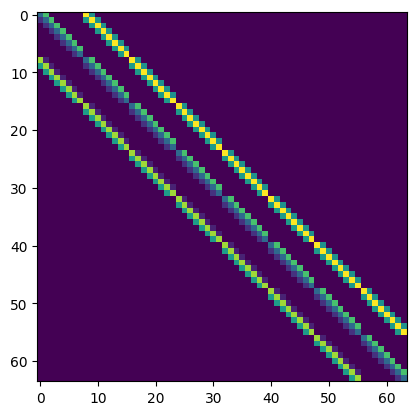

True


In [2]:
import time
import torch
import torch.nn as nn
import torchvision as tv
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, default_collate
import matplotlib.pyplot as plt
import numpy as np
import random
from gcn.gnn import SparseCNN
import os


# set random seed
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_size = (8, 8)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Resize(image_size, antialias=True)])
dataset = tv.datasets.MNIST('./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


model = SparseCNN(1, 10)

if torch.cuda.is_available():
    model.cuda()

if os.path.exists(f'sparse_model_{image_size[0]}.pth'):
    model.load_state_dict(torch.load(f'sparse_model_{image_size[0]}.pth'))

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
temp = model.conv.weight[0, 0].detach().cpu().numpy()
plt.imshow(model.conv.weight[0, 0].detach().cpu().numpy())
plt.show()

total = 0
correct = 0
best_loss = 100
for i in range(20):
    start = time.time()

    for image, label in loader:
        image = image.cuda()
        label = label.cuda()
        optimizer.zero_grad()
        output = model(image)
        loss = criteria(output, label)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), f'sparse_model_{image_size[0]}.pth')
    print(f'loss: {loss.item()}, accuracy: {correct/total*100}%, time: {time.time()-start}')


dataset = tv.datasets.MNIST('./data', train=False, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model.eval()

correct = 0
total = 0
with torch.no_grad():
    for image, label in loader:
        image = image.cuda()
        label = label.cuda()
        output = model(image)
        _, predicted = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

print(f'Accuracy: {correct/total*100}%')
plt.imshow(model.conv.weight[0, 0].detach().cpu().numpy())
plt.show()

print(np.allclose(temp, model.conv.weight[0, 0].detach().cpu().numpy()))

# save model
torch.save(model.state_dict(), 'sparse_model.pth')

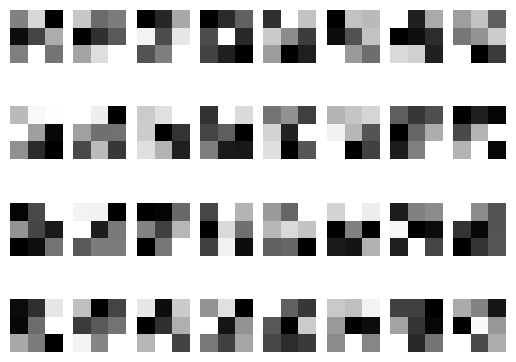

In [9]:
for i in range(32):
    temp = model.conv.weight[i, 0].detach().cpu()[10].numpy()
    temp = temp[temp != 0]
    plt.subplot(4, 8, i+1)
    plt.imshow(temp.reshape(3,3), cmap='gray')
    plt.axis('off')
plt.show()

In [15]:
# get number of learnable parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.numel())

conv.kernel 288
conv.weight 8192
fc.weight 5120
fc.bias 10


In [4]:
# get number of learnable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params} parameters')

13331 parameters


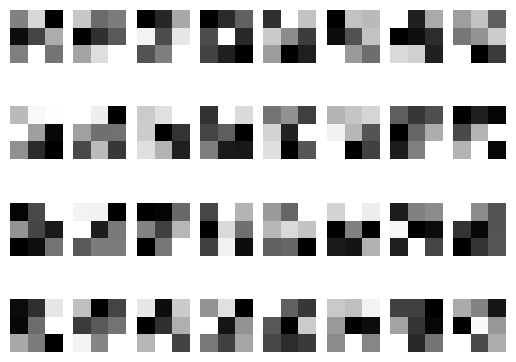

In [2]:
for i in range(32):
    temp = model.conv.weight[i, 0].detach().cpu()[10].numpy()
    temp = temp[temp != 0]
    plt.subplot(4, 8, i+1)
    plt.imshow(temp.reshape(3,3), cmap='gray')
    plt.axis('off')
plt.show()

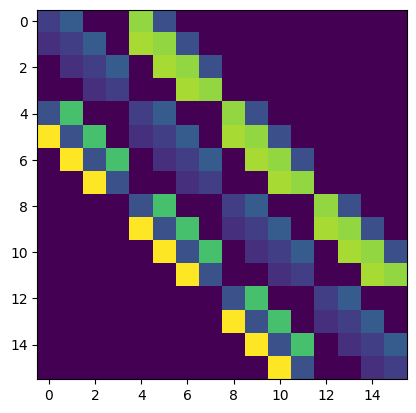

In [4]:
plt.imshow(model.conv.weight[6, 0].detach().cpu())

In [11]:
model.conv.kernel

Parameter containing:
tensor([[0.4963, 0.7682, 0.0885],
        [0.1320, 0.3074, 0.6341],
        [0.4901, 0.8964, 0.4556]], device='cuda:0', requires_grad=True)

In [14]:
model.conv.weight[0, 0].detach().cpu().numpy()[10]

array([-0.        , -0.        , -0.        ,  0.        ,  0.        ,
        2.1905775 ,  0.7415802 ,  0.83530515, -0.        ,  0.7701138 ,
        1.3515583 , -0.8627636 , -0.        ,  1.2783762 ,  1.4323219 ,
        0.53974545], dtype=float32)

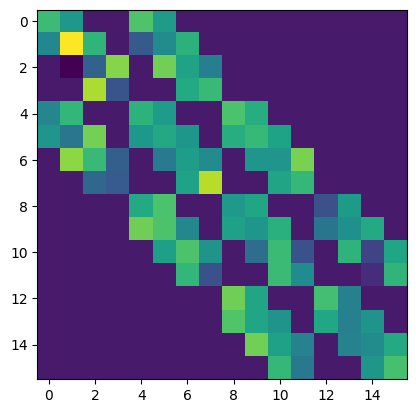

In [3]:
plt.imshow(model.conv.weight[0, 0].detach().cpu().numpy())
plt.show()

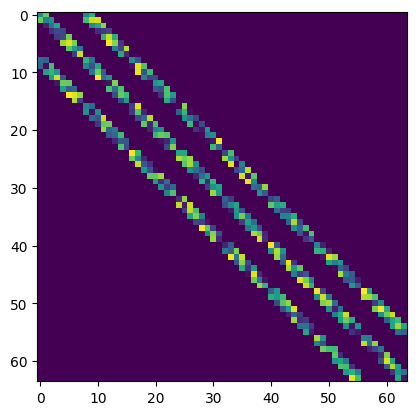

In [5]:
# set random seed
torch.manual_seed(0)
torch.cuda.manual_seed(0)

temp = SparseCNN(1, 10)
temp.cuda()
temp.conv._mask_weights()
plt.imshow(temp.conv.weight.data[0, 0].cpu().numpy())

In [3]:
import torch

class BlockSparseMatrix(torch.autograd.Function):
    def __init__(self, blocks, block_size, shape):
        self.blocks = blocks  # Dictionary of non-empty blocks
        self.block_size = block_size
        self.shape = shape
    
    def to_dense(self):
        """Convert the block-based sparse matrix into a full dense matrix."""
        dense_matrix = torch.zeros(self.shape)
        for (row, col), block in self.blocks.items():
            r_start, r_end = row * self.block_size, (row + 1) * self.block_size
            c_start, c_end = col * self.block_size, (col + 1) * self.block_size
            dense_matrix[r_start:r_end, c_start:c_end] = block
        return dense_matrix


In [4]:
class BlockSparseMatrixAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, blocks, block_indices, block_size, vector):
        """Forward pass for block sparse matrix multiplication."""
        ctx.save_for_backward(blocks, block_indices, block_size, vector)
        result = torch.zeros(vector.shape[0])
        
        # Iterate over each block
        for (row, col), block in blocks.items():
            r_start, r_end = row * block_size, (row + 1) * block_size
            c_start, c_end = col * block_size, (col + 1) * block_size
            
            result[r_start:r_end] += block @ vector[c_start:c_end]
        
        return result

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass to propagate the gradient."""
        blocks, block_indices, block_size, vector = ctx.saved_tensors
        
        # Initialize gradients
        grad_blocks = {}
        grad_vector = torch.zeros_like(vector)
        
        # Compute gradients for each block
        for (row, col), block in blocks.items():
            r_start, r_end = row * block_size, (row + 1) * block_size
            c_start, c_end = col * block_size, (col + 1) * block_size
            
            # Gradient for block
            grad_blocks[(row, col)] = grad_output[r_start:r_end].unsqueeze(1) @ vector[c_start:c_end].unsqueeze(0)
            
            # Gradient for vector
            grad_vector[c_start:c_end] += block.T @ grad_output[r_start:r_end]
        
        return grad_blocks, None, None, grad_vector


In [5]:
blocks = {
    (0, 0): torch.randn(4, 4, requires_grad=True),
    (1, 0): torch.randn(4, 4, requires_grad=True),
    (1, 1): torch.randn(4, 4, requires_grad=True)
}

block_indices = [(0, 0), (1, 0), (1, 1)]
block_size = 4
vector = torch.randn(8, requires_grad=True)

# Using the block-based sparse matrix for matrix-vector multiplication
result = BlockSparseMatrixAutograd.apply(blocks, block_indices, block_size, vector)
result.backward(torch.ones_like(result))

# Check gradients
print(blocks[(0, 0)].grad)
print(vector.grad)


TypeError: save_for_backward can only save variables, but argument 0 is of type dict

/home/hesam/miniconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loss: 1.5501701831817627, accuracy: 81.71%, time: 28.30s
loss: 3.2725276947021484, accuracy: 84.15%, time: 28.21s
loss: 1.9858423471450806, accuracy: 85.38%, time: 28.40s
loss: 1.385349154472351, accuracy: 86.19%, time: 27.88s
loss: 1.875110387802124, accuracy: 86.82%, time: 27.99s
loss: 0.8600005507469177, accuracy: 87.32%, time: 27.95s
loss: 1.0058120489120483, accuracy: 87.66%, time: 27.72s
loss: 0.35432708263397217, accuracy: 87.97%, time: 28.09s
loss: 1.5728849172592163, accuracy: 88.30%, time: 28.48s
loss: 3.0018248558044434, accuracy: 88.52%, time: 28.67s
loss: 1.82009756565094, accuracy: 88.73%, time: 28.49s
loss: 0.6282989382743835, accuracy: 88.94%, time: 28.63s
loss: 2.0359387397766113, accuracy: 89.13%, time: 28.21s
loss: 11.39993667602539, accuracy: 89.28%, time: 28.21s
loss: 0.43373867869377136, accuracy: 89.43%, time: 28.23s
loss: 4.986561298370361, accuracy: 89.58%, time: 28.27s
loss: 5.1664814949035645, accuracy: 89.71%, time: 28.22s
loss: 1.5063667297363281, accuracy:

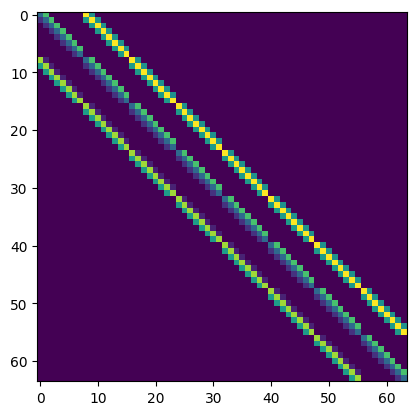

In [1]:
import time
import torch
import torch.nn as nn
import torchvision as tv
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, default_collate
import matplotlib.pyplot as plt
import random
from gcn.gnn import BlockSparseCNN


# set random seed
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_size = (28, 28)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Resize(image_size, antialias=True)])
dataset = tv.datasets.MNIST('./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


model = BlockSparseCNN(1, 10)

if torch.cuda.is_available():
    model.cuda()


criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model = model.cuda()

correct = 0
total = 0


for i in range(20):
    start = time.time()
    for image, label in loader:
        image = image.cuda()
        label = label.cuda()
        optimizer.zero_grad()
        output = model(image)
        loss = criteria(output, label)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    print(f'loss: {loss.item()}, accuracy: {correct/total*100:.2f}%, time: {time.time()-start:.2f}s')


dataset = tv.datasets.MNIST('./data', train=False, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model.eval()

correct = 0
total = 0
with torch.no_grad():
    for image, label in loader:
        image = image.cuda()
        label = label.cuda()
        output = model(image)
        _, predicted = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

print(f'Accuracy: {correct/total*100}%')
plt.imshow(model.conv.coeff.to_dense()[0, 0].detach().cpu().numpy())
plt.show()

# save model
torch.save(model.state_dict(), 'block_sparse_model_28.pth')